In [24]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import pickle as pkl

from getEmbeddings import getEmbeddings
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from skorch import NeuralNetClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
sys.path.append('..')
from tqdm import tqdm
import acd
from copy import deepcopy
import transform_wrappers
device = 'cuda'
from style import *

class FNN(nn.Module):
    def __init__(self):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(5000, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 256)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 80)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(80, 2)
        self.use_softmax = True

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        if self.use_softmax:
            x = F.softmax(x, dim=1)
        return x

# import data

In [3]:
data_dir_path = './datasets'

# Import `fake_or_real_news.csv`
df = pd.read_csv(data_dir_path + "/train.csv")

# Set `y`
X = df['text']
y = df.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
df.head()

# must use raw term counts for LDA because it is a probabilistic graphical model
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=5000, stop_words='english')

# fit and transform the training data into bag of words
bag_of_words_train = count_vectorizer.fit_transform(X_train.astype('U'))
bag_of_words_test = count_vectorizer.transform(X_test.astype('U'))
feature_names = count_vectorizer.get_feature_names()

# run/load lda

In [4]:
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx), end=' ')
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]) + '...')



# Run LDA
num_topics = 10
# lda = LatentDirichletAllocation(n_components=num_topics, random_state=42).fit(bag_of_words_train)
# pkl.dump(lda, open('lda_10.pkl', 'wb'))
lda = pkl.load(open('lda_10.pkl', 'rb'))

# display        
num_top_words = 10
display_topics(lda, feature_names, num_top_words)        

Topic 0: said percent new year company million 000 money years companies...
Topic 1: mr said trump president ms court new mrs campaign house...
Topic 2: trump president obama donald people house election said party white...
Topic 3: said police people state city syria attack officers killed military...
Topic 4: news twitter com 2016 media facebook 2017 breitbart video на...
Topic 5: people world black israel political state women war america students...
Topic 6: like just people time don know way life make good...
Topic 7: russia united states government russian war foreign china president military...
Topic 8: said mr ms new la like york year city years...
Topic 9: clinton hillary election campaign fbi trump emails investigation comey email...


# load embeddings
Previously was using from doc2vec to embed each document as a 300-dim vector.

In [ ]:
'''
print('getting doc2vec embdeddings...')
xtr, xte, ytr, yte = getEmbeddings("datasets/train.csv")
np.save('./xtr', xtr)
np.save('./xte', xte)
np.save('./ytr', ytr)
np.save('./yte', yte)

# prepare data
xtr = np.load('./xtr.npy').astype(np.float32)
xte = np.load('./xte.npy').astype(np.float32)
ytr = np.load('./ytr.npy')
yte = np.load('./yte.npy')

# encode the labels
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y = np_utils.to_categorical((label_encoder.transform(y_train))).astype(np.int64)
encoded_y_test = np_utils.to_categorical((label_encoder.transform(y_test))).astype(np.int64)
'''

In [100]:
# # fit model (only takes about a minute on gpu)
# np.random.seed(42)
# torch.manual_seed(42)
# net = NeuralNetClassifier(
#     FNN,
#     max_epochs=10,
#     lr=0.01,
#     # Shuffle training data on each epoch
#     iterator_train__shuffle=True,
#     train_split=None,
# )
# net.fit(bag_of_words_train.astype(np.float32), y_train)
# pkl.dump(net, open('model.pkl', 'wb'))
# print("model saved!")

  epoch    train_loss     dur
-------  ------------  ------
      1        0.6851  5.8618
      2        0.6314  5.8392
      3        0.5183  5.9091
      4        0.4159  5.8590
      5        0.3370  5.8460
      6        0.2740  5.8234
      7        0.2240  5.8654
      8        0.1848  5.8531
      9        0.1551  5.8403
     10        0.1319  6.1565
Model Trained!


# load + interpret the model

In [5]:
# evaluate model
net = pkl.load(open('model.pkl', 'rb'))
probabs = net.predict_proba(bag_of_words_test.astype(np.float32))
y_pred = np.argmax(probabs, axis=1)
acc = np.mean(y_pred == y_test)
print(f"acc: {acc:0.3f}")

acc: 0.948


In [6]:
fnn = net.module_
fnn.use_softmax = False
print(fnn)

FNN(
  (fc1): Linear(in_features=5000, out_features=256, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=256, out_features=80, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=80, out_features=2, bias=True)
)


In [7]:
D = lda.components_
print(D.shape)

(10, 5000)


In [8]:
transform = transform_wrappers.lay_from_w(D)
# norm = transform_wrappers.NormLayer(mu=0.1307, std=0.3081)
# reshape = transform_wrappers.ReshapeLayer(shape=(1, 28, 28))
net = transform_wrappers.Net_with_transform(fnn, transform=transform).to(device)
#                                             reshape=reshape,
#                                             use_logits=True).to(device)
# print(list(net.modules()))

In [9]:
topics_test = lda.transform(bag_of_words_test)

In [10]:
x = torch.Tensor(topics_test[0:1]).to(device)
print(x.shape)

torch.Size([1, 10])


In [11]:
def calc_scores(topics, net):
    results = {
        'scores': [],
        'logits': [],
        'class_pred': []
    }
    for i in tqdm(range(topics.shape[0])): # 10000 pts total
        x_t = topics[i: i + 1]
        x_t_tensor = torch.Tensor(x_t).to(device)

        pred = net(deepcopy(x_t_tensor)).cpu().detach().numpy()
        results['logits'].append(deepcopy(pred))
        results['class_pred'].append(np.argmax(pred))
        # x.requires_grad = False
        sweep_dim = 1
        tiles = acd.tiling_2d.gen_tiles(x_t, fill=0, method='cd', sweep_dim=sweep_dim)
        cd_scores_im = acd.get_scores_2d(net, method='cd', ims=tiles, im_torch=x_t_tensor, device='cuda')
        results['scores'].append(deepcopy(cd_scores_im))

        if i == 100 or i % 1000 == 0:
            # 
            pkl.dump(results, open(f'lda_scores_{i}.pkl', 'wb'))
    pkl.dump(results, open(f'lda_scores_{i}.pkl', 'wb'))
# calc_scores(topics_test, net)

In [12]:
# plot scores across bases
results = pkl.load(open(f'lda_scores_{4159}.pkl', 'rb'))
scores = np.array(results['scores']) # (num points, num_bases, num_classes)
logits = np.array(results['logits']) # (num points, 1, num_classes)
class_preds = np.array(results['class_pred']) # (num points, )
titles = []
scores_all = np.mean(scores, axis=0)
titles = np.argmax(scores, axis=-1)

mean contribution to "fake" class for each topic for points which were correctly predicted as fake

In [36]:
num_top_words = 10
# idxs = np.ones(y_test.shape).astype(np.int) # look at all points
idxs = np.logical_and(y_test == 1, class_preds == 1)
# print('Topic\t&\tMean contribution\t&\tTop words for topic \\\\')
# print('\\hline')
scores_list = []
words_list = []
for i in range(10):
    topic = lda.components_[i]
    words = " ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]])
    score = np.mean(scores[:, i, 1][idxs])
    scores_list.append(score)
    words_list.append(words)
    print(f"{i + 1}\t&\t{score:0.1f}\t&\t{words}\\\\")
#     hist = plt.hist(scores[:, i, 1][idxs], alpha=0.5, label=str(i), bins=100)    
#     hist = plt.hist(scores[:, i, 1][idxs] / logits[idxs, 0, 1], alpha=1, label=str(i), bins=100)    
#     plt.yscale('log')
#     plt.legend()
# plt.show()

1	&	-121.5	&	said percent new year company million 000 money years companies\\
2	&	-111.8	&	mr said trump president ms court new mrs campaign house\\
3	&	-205.4	&	trump president obama donald people house election said party white\\
4	&	-62.3	&	said police people state city syria attack officers killed military\\
5	&	59.9	&	news twitter com 2016 media facebook 2017 breitbart video на\\
6	&	87.1	&	people world black israel political state women war america students\\
7	&	443.6	&	like just people time don know way life make good\\
8	&	-29.5	&	russia united states government russian war foreign china president military\\
9	&	-95.4	&	said mr ms new la like york year city years\\
10	&	1199.6	&	clinton hillary election campaign fbi trump emails investigation comey email\\


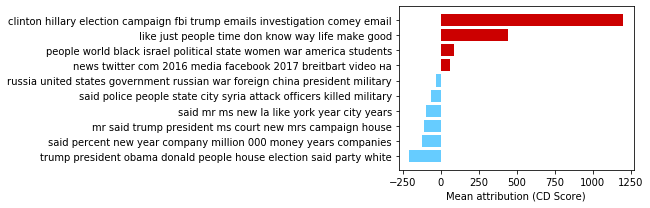

In [43]:
scores_list = np.array(scores_list)
words_list = np.array(words_list)
args = scores_list.argsort()
scores_list = scores_list[args]
words_list = words_list[args]
n = scores_list.shape[0]
colors = np.array([cr for i in range(n)])
colors[scores_list < 0] = cb
plt.figure(figsize=(9, 3))
plt.barh(range(n), scores_list, color=colors)
plt.yticks(range(n), words_list)
plt.xlabel('Mean attribution (CD Score)')
plt.tight_layout()
plt.savefig('fig_fakenews.pdf')
plt.show()